In [4]:
# Common imports

import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from sklearn import preprocessing
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from datetime import datetime
import time

In [5]:
url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_FB.csv'
fb_df = pd.read_csv(url, error_bad_lines=False)
fb_df.head(5)

,timestamp,value
0,2015-02-26 21:42:53,53
1,2015-02-26 21:47:53,64
2,2015-02-26 21:52:53,49
3,2015-02-26 21:57:53,48
4,2015-02-26 22:02:53,22


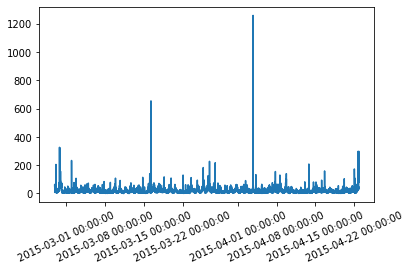

In [6]:
def plot_dates_values(data):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, values)
    plt.show()

plot_dates_values(fb_df)

Text(0, 0.5, 'correlation coeff')

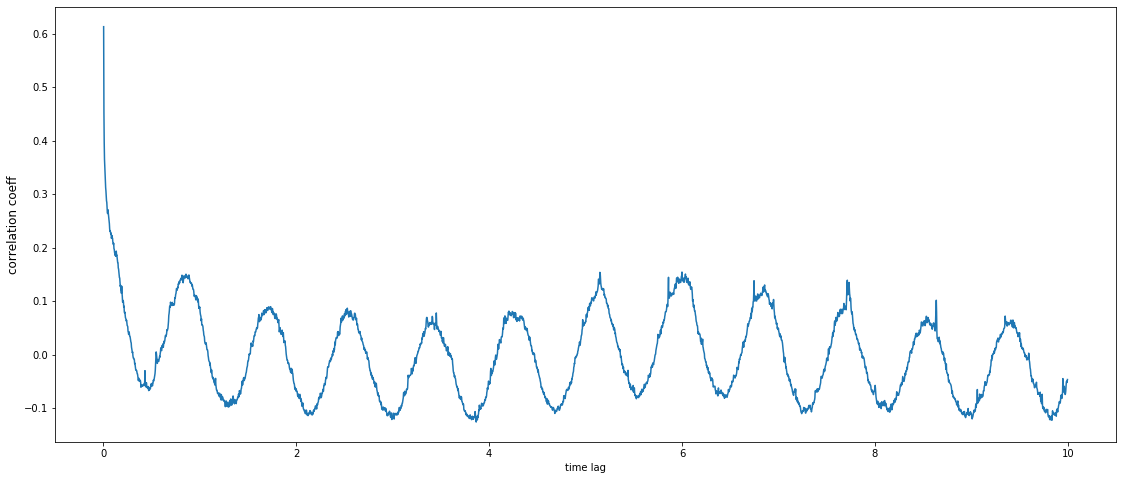

In [7]:
timeLags = np.arange(1,10*48*7)
autoCorr = [fb_df.value.autocorr(lag=dt) for dt in timeLags]
plt.figure(figsize=(19,8))
plt.plot(1.0/(48*7)*timeLags, autoCorr)
plt.xlabel('time lag')
plt.ylabel('correlation coeff', fontsize=12)

In [8]:
fb_df.isnull().values.any()

False

In [9]:
fb_df.value.describe()

count    15833.000000
mean        17.811280
std         19.740055
min          0.000000
25%          9.000000
50%         14.000000
75%         22.000000
max       1258.000000
Name: value, dtype: float64

In [10]:
fb_df['timestamp'] = pd.to_datetime(fb_df['timestamp'])
fb_df['yr'] = fb_df.timestamp.dt.year
fb_df['mt'] = fb_df.timestamp.dt.month
fb_df['d'] = fb_df.timestamp.dt.day
fb_df['H'] = fb_df.timestamp.dt.hour

print(fb_df.shape)
fb_df.head()

(15833, 6)


,timestamp,value,yr,mt,d,H
0,2015-02-26 21:42:53,53,2015,2,26,21
1,2015-02-26 21:47:53,64,2015,2,26,21
2,2015-02-26 21:52:53,49,2015,2,26,21
3,2015-02-26 21:57:53,48,2015,2,26,21
4,2015-02-26 22:02:53,22,2015,2,26,22


In [11]:
### CREATE WEEKDAY FEATURE AND COMPUTE THE MEAN FOR WEEKDAYS AT EVERY HOURS ###

fb_df['weekday'] = fb_df.timestamp.dt.weekday
fb_df['weekday_hour'] = fb_df.weekday.astype(str) +' '+ fb_df.H.astype(str)
fb_df['m_weekday'] = fb_df.weekday_hour.replace(fb_df[:5000].groupby('weekday_hour')['value'].mean().to_dict())

In [12]:
#Preparing the data for LSTM model
data_n = fb_df[['value', 'yr', 'mt', 'd', 'H']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)

In [13]:
#hyper-parameters and training/Test size
prediction_time = 1 
testdatasize = 3114
unroll_length = 50
unroll_length2 = 30
unroll_length3 = 60

testdatacut = testdatasize + unroll_length  + 1
testdatacut2 = testdatasize + unroll_length2  + 1
testdatacut3 = testdatasize + unroll_length3  + 1

#Training data
x_train = data_n[0:-prediction_time-testdatacut].values
x_train2 = data_n[0:-prediction_time-testdatacut2].values
x_train3 = data_n[0:-prediction_time-testdatacut3].values

y_train = data_n[prediction_time:-testdatacut][0].values
y_train2 = data_n[prediction_time:-testdatacut2][0].values
y_train3 = data_n[prediction_time:-testdatacut3][0].values

#Test data
x_test = data_n[0-testdatacut:-prediction_time].values
x_test2 = data_n[0-testdatacut2:-prediction_time].values
x_test3 = data_n[0-testdatacut3:-prediction_time].values

y_test = data_n[prediction_time-testdatacut: ][0].values
y_test2 = data_n[prediction_time-testdatacut2: ][0].values
y_test3 = data_n[prediction_time-testdatacut3: ][0].values

In [14]:
#Different Window size and the size of the output sequence

def unroll(data, sequence_length):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

#Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]


x_train2 = unroll(x_train2,unroll_length2)
x_test2  = unroll(x_test2,unroll_length2)
y_train2 = y_train2[-x_train2.shape[0]:]
y_test2  = y_test2[-x_test2.shape[0]:]

x_train3 = unroll(x_train3,unroll_length3)
x_test3  = unroll(x_test3,unroll_length3)
y_train3 = y_train3[-x_train3.shape[0]:]
y_test3  = y_test3[-x_test3.shape[0]:]


#Shape of the data
print("x_train", x_train.shape)
print("x_train2", x_train2.shape)
print("x_train3", x_train3.shape)

print('-------------------------')

print("y_train", y_train.shape)
print("y_train2", y_train2.shape)
print("y_train3", y_train3.shape)

print('-------------------------')

print("x_test", x_test.shape)
print("x_test2", x_test2.shape)
print("x_test3", x_test3.shape)

print('-------------------------')

print("y_test", y_test.shape)
print("y_test2", y_test2.shape)
print("y_test3", y_test3.shape)

x_train (12617, 50, 5)
x_train2 (12657, 30, 5)
x_train3 (12597, 60, 5)
-------------------------
y_train (12617,)
y_train2 (12657,)
y_train3 (12597,)
-------------------------
x_test (3114, 50, 5)
x_test2 (3114, 30, 5)
x_test3 (3114, 60, 5)
-------------------------
y_test (3114,)
y_test2 (3114,)
y_test3 (3114,)


In [15]:
#Building the model
model = Sequential()

model.add(LSTM(input_dim=x_train.shape[-1], return_sequences=True, units=50))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('softmax'))

model.compile(loss='mse', optimizer='adam')

model.fit(x_train, y_train, batch_size=256, epochs=100, validation_split=0.1)

Train on 11355 samples, validate on 1262 samples
Epoch 1/100
11355/11355 [==============================] - 23s 2ms/sample - loss: 2.1224 - val_loss: 1.3903
Epoch 2/100
11355/11355 [==============================] - 18s 2ms/sample - loss: 2.1224 - val_loss: 1.3903
Epoch 3/100
11355/11355 [==============================] - 18s 2ms/sample - loss: 2.1224 - val_loss: 1.3903
Epoch 4/100
11355/11355 [==============================] - 18s 2ms/sample - loss: 2.1224 - val_loss: 1.3903
Epoch 5/100
11355/11355 [==============================] - 18s 2ms/sample - loss: 2.1224 - val_loss: 1.3903
Epoch 6/100
11355/11355 [==============================] - 18s 2ms/sample - loss: 2.1224 - val_loss: 1.3903
Epoch 7/100
11355/11355 [==============================] - 18s 2ms/sample - loss: 2.1224 - val_loss: 1.3903
Epoch 8/100
11355/11355 [==============================] - 18s 2ms/sample - loss: 2.1224 - val_loss: 1.3903
Epoch 9/100
11355/11355 [==============================] - 18s 2ms/sample - loss: 2.122

Epoch 76/100
11355/11355 [==============================] - 27s 2ms/sample - loss: 2.1224 - val_loss: 1.3903
Epoch 77/100
11355/11355 [==============================] - 27s 2ms/sample - loss: 2.1224 - val_loss: 1.3903
Epoch 78/100
11355/11355 [==============================] - 27s 2ms/sample - loss: 2.1224 - val_loss: 1.3903
Epoch 79/100
11355/11355 [==============================] - 27s 2ms/sample - loss: 2.1224 - val_loss: 1.3903
Epoch 80/100
11355/11355 [==============================] - 27s 2ms/sample - loss: 2.1224 - val_loss: 1.3903
Epoch 81/100
11355/11355 [==============================] - 26s 2ms/sample - loss: 2.1224 - val_loss: 1.3903
Epoch 82/100
11355/11355 [==============================] - 26s 2ms/sample - loss: 2.1224 - val_loss: 1.3903
Epoch 83/100
11355/11355 [==============================] - 26s 2ms/sample - loss: 2.1224 - val_loss: 1.3903
Epoch 84/100
11355/11355 [==============================] - 27s 2ms/sample - loss: 2.1224 - val_loss: 1.3903
Epoch 85/100
11355/

In [16]:
#Building the model 2


model2 = Sequential()

model2.add(LSTM(input_dim=x_train2.shape[-1], return_sequences=True, units=30))
model2.add(Dropout(0.2))

model2.add(LSTM(100, return_sequences=False))
model2.add(Dropout(0.2))

model2.add(Dense(units=1))
model2.add(Activation('softmax'))

model2.compile(loss='mse', optimizer='adam')
model2.summary()
model2.fit(x_train2, y_train2, batch_size=256, epochs=100, validation_split=0.1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 30)          4320      
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 30)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               52400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 56,821
Trainable params: 56,821
Non-trainable params: 0
__________________________________________________

In [17]:
#Building the model 3


model3 = Sequential()

model3.add(LSTM(input_dim=x_train3.shape[-1], return_sequences=True, units=60))
model3.add(Dropout(0.2))

model3.add(LSTM(100, return_sequences=False))
model3.add(Dropout(0.2))

model3.add(Dense(units=1))
model3.add(Activation('softmax'))

model3.compile(loss='mse', optimizer='adam')
model3.summary()
model3.fit(x_train3, y_train3, batch_size=256, epochs=100, validation_split=0.1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 60)          15840     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 60)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               64400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 80,341
Trainable params: 80,341
Non-trainable params: 0
__________________________________________________

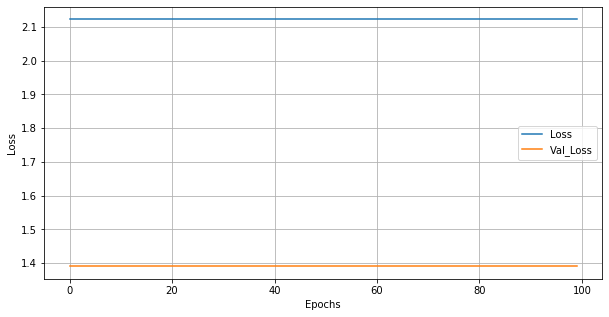

In [18]:
#Visualizing training and validaton loss
plt.figure(figsize = (10, 5))
plt.plot(model.history.history['loss'], label = 'Loss')
plt.plot(model.history.history['val_loss'], Label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

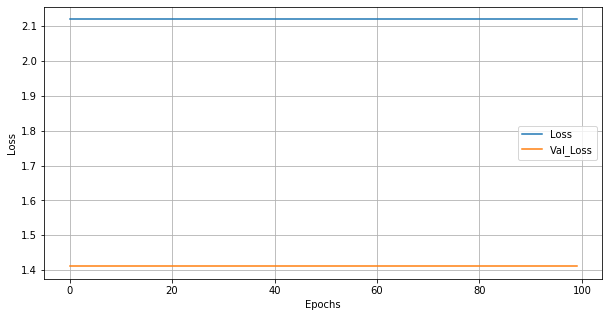

In [19]:
#Visualizing training and validaton loss
plt.figure(figsize = (10, 5))
plt.plot(model2.history.history['loss'], label = 'Loss')
plt.plot(model2.history.history['val_loss'], Label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

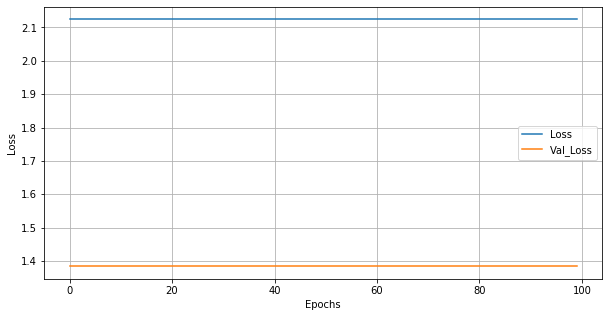

In [20]:
#Visualizing training and validaton loss
plt.figure(figsize = (10, 5))
plt.plot(model3.history.history['loss'], label = 'Loss')
plt.plot(model3.history.history['val_loss'], Label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

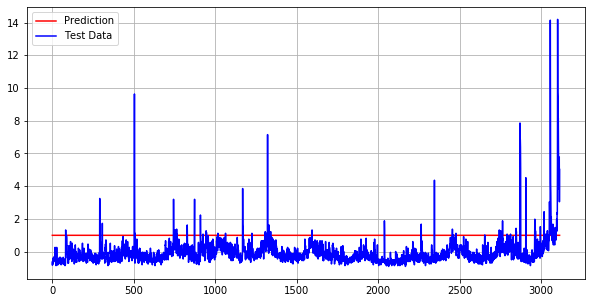

In [21]:
#creating the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))


#Plotting the prediction and groundtruth
plt.figure(figsize = (10, 5))
plt.plot(p,color='red', label='Prediction')
plt.plot(y_test,color='blue', label='Test Data')
plt.legend(loc='upper left')
plt.grid()
plt.legend()

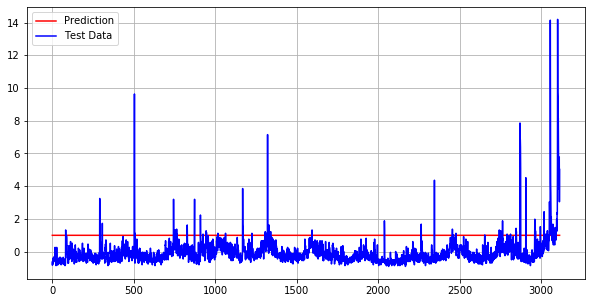

In [22]:
#creating the list of difference between prediction and test data
loaded_model = model2
diff=[]
ratio=[]
p = loaded_model.predict(x_test2)
for u in range(len(y_test2)):
    pr = p[u][0]
    ratio.append((y_test2[u]/pr)-1)
    diff.append(abs(y_test2[u]- pr))


#Plotting the prediction and groundtruth
plt.figure(figsize = (10, 5))
plt.plot(p,color='red', label='Prediction')
plt.plot(y_test2,color='blue', label='Test Data')
plt.legend(loc='upper left')
plt.grid()
plt.legend()

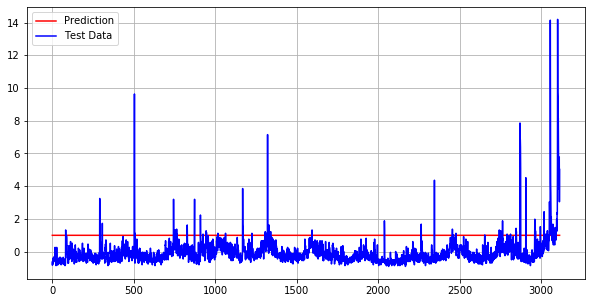

In [23]:
#creating the list of difference between prediction and test data
loaded_model = model3
diff=[]
ratio=[]
p = loaded_model.predict(x_test3)
for u in range(len(y_test3)):
    pr = p[u][0]
    ratio.append((y_test3[u]/pr)-1)
    diff.append(abs(y_test3[u]- pr))


#Plotting the prediction and groundtruth
plt.figure(figsize = (10, 5))
plt.plot(p,color='red', label='Prediction')
plt.plot(y_test3,color='blue', label='Test Data')
plt.legend(loc='upper left')
plt.grid()
plt.legend()

In [24]:
#Pick the most distant prediction/reality data points as anomalies

# Anomaly estimated population
outliers_fraction = 0.01
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()

#Data with anomaly label
test = (diff >= threshold).astype(int)
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
fb_df['anomaly'] = complement.append(test, ignore_index='True')
print(fb_df['anomaly'].value_counts())

0    15801
1       32
Name: anomaly, dtype: int64


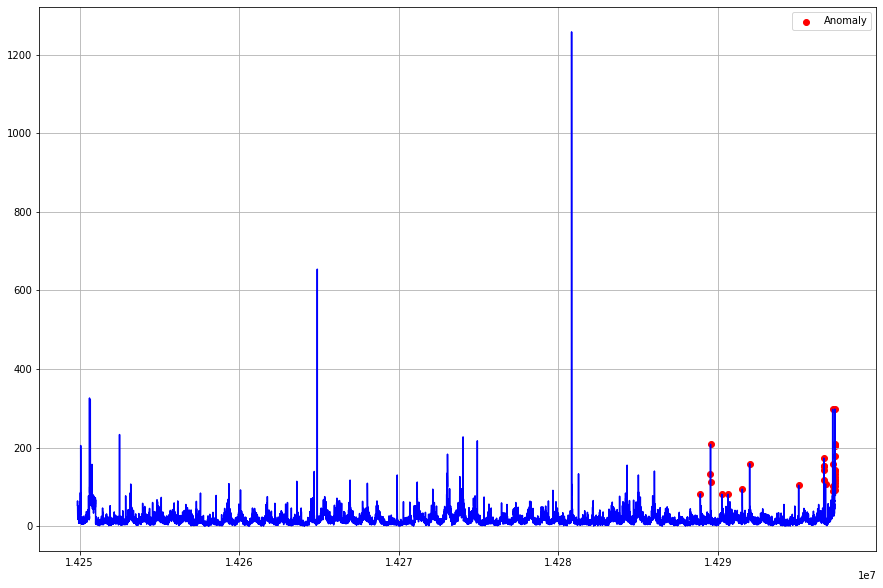

In [25]:
#Visualizing anomalies (Red Dots)

plt.figure(figsize=(15,10))
fb_df['time_epoch'] = (fb_df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
a = fb_df.loc[fb_df['anomaly'] == 1, ['time_epoch', 'value']] #anomaly
plt.plot(fb_df['time_epoch'], fb_df['value'], color='blue')
plt.scatter(a['time_epoch'],a['value'], color='red', label = 'Anomaly')
plt.grid()
plt.legend()

In [54]:
#Pick the most distant prediction/reality data points as anomalies

# Anomaly estimated population
outliers_fraction = 0.005
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()

#Data with anomaly label
test = (diff >= threshold).astype(int)
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
fb_df['anomaly'] = complement.append(test, ignore_index='True')
print(fb_df['anomaly'].value_counts())

0    15817
1       16
Name: anomaly, dtype: int64


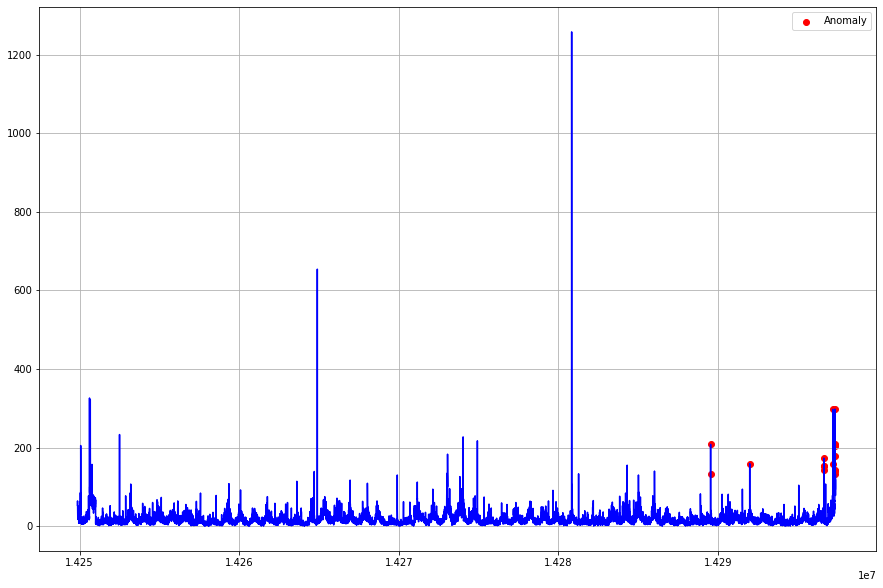

In [55]:
#Visualizing anomalies (Red Dots)

plt.figure(figsize=(15,10))
fb_df['time_epoch'] = (fb_df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
a = fb_df.loc[fb_df['anomaly'] == 1, ['time_epoch', 'value']] #anomaly
plt.plot(fb_df['time_epoch'], fb_df['value'], color='blue')
plt.scatter(a['time_epoch'],a['value'], color='red', label = 'Anomaly')
plt.grid()
plt.legend()

In [68]:
#Pick the most distant prediction/reality data points as anomalies

# Anomaly estimated population
outliers_fraction = .003
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()

#Data with anomaly label
test = (diff >= threshold).astype(int)
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
fb_df['anomaly'] = complement.append(test, ignore_index='True')
print(fb_df['anomaly'].value_counts())

0    15824
1        9
Name: anomaly, dtype: int64


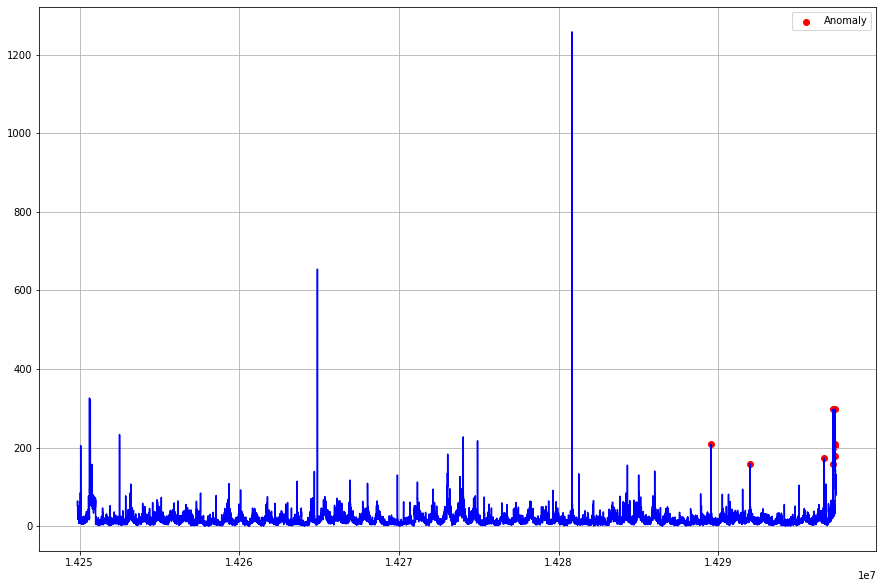

In [69]:
#Visualizing anomalies (Red Dots)

plt.figure(figsize=(15,10))
fb_df['time_epoch'] = (fb_df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
a = fb_df.loc[fb_df['anomaly'] == 1, ['time_epoch', 'value']] #anomaly
plt.plot(fb_df['time_epoch'], fb_df['value'], color='blue')
plt.scatter(a['time_epoch'],a['value'], color='red', label = 'Anomaly')
plt.grid()
plt.legend()

#### The results were very interesting. As you can see the further the distance chosen of the anamoly, the more anamolies are shown. An outlier of .01 seems to be the sweet spot for this data set while other outliers either show too little anamolies are show points that aren't truly anamolies. I believe the anamolies for Facebook mentioned tweets are probably just tweets about Facebook after some news came out for the company.